In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [3]:
import seaborn as sns
def set_plt_params():
    sns.set_theme()
    params = {
        "font.family": "Serif",
        "font.serif": "Roman", 
        "text.usetex": True,
        "axes.titlesize": "large",
        "axes.labelsize": "large",
        "xtick.labelsize": "large",
        "ytick.labelsize": "large",
        "legend.fontsize": "medium"
    }
    plt.rcParams.update(params)
# set_plt_params()

### Franke's function

In [3]:
def franke_function(x1, x2, noise_factor=0):
    """The Franke function is a bivariate test function.

    Args:
        x (np.ndarray): x-values
        y (np.ndarray): y-values
        noise_factor (int): adds noise to function, default is 0

    Returns:
        np.ndarray: array of function values
    """
    m, n = len(x1), len(x2)
    noise = np.random.normal(0, 1, n*m).reshape(m, n)
    
    term1 = 0.75*np.exp(-(0.25*(9*x1-2)**2) - 0.25*((9*x2-2)**2))
    term2 = 0.75*np.exp(-((9*x1+1)**2)/49.0 - 0.1*(9*x2+1))
    term3 = 0.5*np.exp(-(9*x1-7)**2/4.0 - 0.25*((9*x2-3)**2))
    term4 = -0.2*np.exp(-(9*x1-4)**2 - (9*x2-7)**2)

    franke = term1 + term2 + term3 + term4

    return franke + noise_factor*noise

In [4]:
def design_matrix(x1, x2, degree):
	"""Create design matrix for polynomial degree n with dimension determined
	by the size of input arrays and degree.
	
	Args:
	    x1 (np.ndarray): x1-values, 1D or 2D array
		x2 (np.ndarray): x2-values, 1D or 2D array
        degree (int): order of polynomial degree
		
	Returns:
        np.ndarray: array with shape (len(x)*len(y), degree)
    """
	if len(x1.shape) > 1:
		x1 = np.ravel(x1)
		x2 = np.ravel(x2)

	m = len(x1)
	# Number of elements in beta
	n = int((degree+1)*(degree+2)/2)
	X = np.ones((m, n))

	for i in range(1, degree+1):
		q = int((i)*(i+1)/2)
		for j in range(i + 1):
			X[:, q+j] = (x1**(i-j))*(x2**j)

	return X

In [5]:
def mse(y_true, y_pred):
	"""Calculate the mean square error of the fit.
	
	Args:
	    y_true (np.ndarray): data to fit
		model (np.ndarray): predicted model
		
	Returns:
	    np.ndarray: mean square error of fit
	"""
	return np.sum((y_true - y_pred)**2) / len(y_true)


def r2(y_true, y_pred):
	"""Calculate the R2 score of the fit

    Args:
        data (np.ndarray): original data to fit
        model (np.ndarray): predicted model
		
	Returns:
	    np.ndarray: R2 score of fit
    """
	return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

In [6]:
class OLSRegression:

    def __init__(self) -> None:
        self._beta = None
    
    @property
    def beta(self):
        return self._beta

    def fit(self, X_train, y_train):
        XT = X_train.T
        XTX = XT @ X_train
        self._beta = np.linalg.pinv(XTX) @ XT @ y_train 

    def predict(self, X_test):
        y_pred = X_test @ self._beta
        return y_pred 

In [17]:
N = 40
P = 5+1
x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 1)

In [9]:
y.ravel().shape

(1600,)

In [18]:
train_mse = np.zeros(P)
train_r2 = np.zeros(P)
test_mse = np.zeros(P)
test_r2 = np.zeros(P)
betas = []
# beta_mean = []
# beta_std = []

In [19]:
for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=12)

    model = OLSRegression()
    model.fit(X_train, y_train)

    beta = model.beta
    betas.append(beta)
    # beta_mean.append(np.mean(beta))
    # beta_std.append(np.std(beta))

    y_tilde = model.predict(X_train)
    y_pred = model.predict(X_test)

    train_mse[p] = mse(y_train, y_tilde)
    train_r2[p] = r2(y_train, y_tilde)
    test_mse[p] = mse(y_test, y_pred)
    test_r2[p] = r2(y_test, y_pred)

### Plot beta-values

In [48]:
def plot_beta(betas, figname=None):
    M = len(betas)
    c = sns.color_palette("mako", n_colors=M, as_cmap=False)
    # x_ticks = [rf"$\beta_{i}$" for i in range(len(betas[-1]))]
    print(c)
    fig, ax = plt.subplots()
    for i in range(M):
        ax.plot(betas[i], 'o-', color=c[i], label=f"{i}")
        # x_ticks.append(rf"$\beta_{i}$")
    ax.legend(title="Degree")
    ax.set_xticks(np.arange(len(betas[-1])))

    if figname is not None:
        fig.savefig(f"latex/figures/{figname}.pdf")
        
    plt.show()

[(0.18195582, 0.11955283, 0.23136943), (0.25307401, 0.23772973, 0.48316271), (0.21607792, 0.39736958, 0.61948028), (0.20344718, 0.56074869, 0.65649508), (0.25187832, 0.71827158, 0.67872193), (0.54578602, 0.8544913, 0.69848331)]


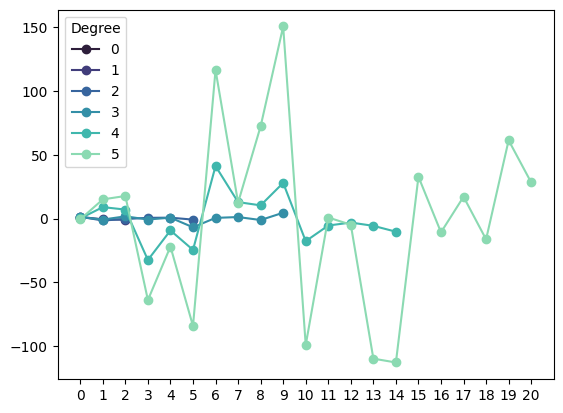

In [49]:
plot_beta(betas)

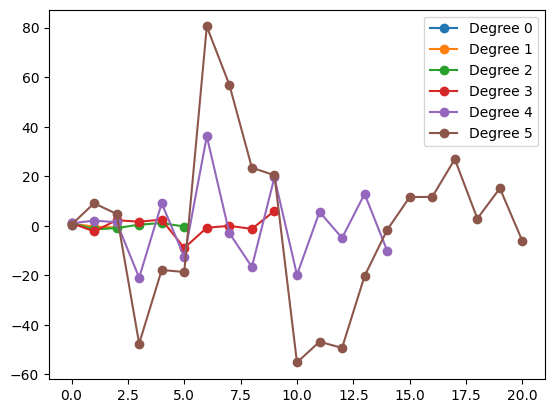

In [12]:
fig, ax = plt.subplots()
#for i in range(P):
ax.plot(betas[0], 'o-', label='Degree 0')
ax.plot(betas[1], 'o-', label='Degree 1')
ax.plot(betas[2], 'o-', label='Degree 2')
ax.plot(betas[3], 'o-', label='Degree 3')
ax.plot(betas[4], 'o-', label='Degree 4')
ax.plot(betas[5], 'o-', label='Degree 5')
    # ax.plot(beta_std[p], 'o', label=rf'$\beta_{i}$')
ax.legend()
fig.savefig('../latex/figures/betas.pdf')

### Plot MSE and R2-scores

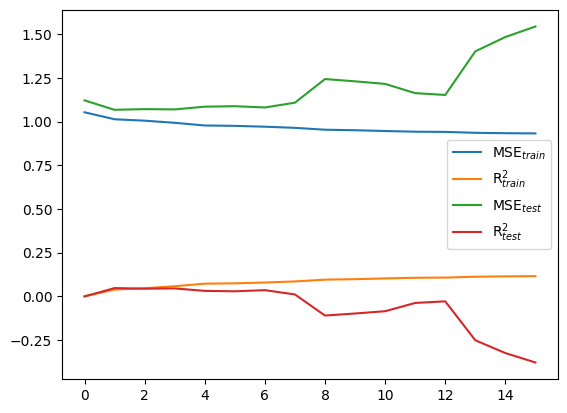

In [13]:
fig, ax = plt.subplots()
ax.plot(np.arange(P), train_mse, label=r'MSE$_{train}$')
ax.plot(np.arange(P), train_r2, label=r'R$^{2}_{train}$')
ax.plot(np.arange(P), test_mse, label=r'MSE$_{test}$')
ax.plot(np.arange(P), test_r2, label=r'R$^{2}_{test}$')
ax.legend()
# ax.set_yscale('log')
plt.show()

## Ridge

In [14]:
class RidgeRegression:

    def __init__(self, lmbda) -> None:
        self._lmbda = lmbda
        self._beta = None

    @property
    def beta(self):
        return self._beta

    def fit(self, X_train, y_train):
        XT = X_train.T
        XTX = XT @ X_train
        self._beta = np.linalg.pinv(XTX + self._lmbda*np.eye(len(XTX))) @ XT @ y_train 
        return self

    def predict(self, X_test):
        y_pred = X_test @ self._beta
        return y_pred 

In [15]:
N = 40
P = 15+1
n_lmbdas = 8
lmbdas = [1/(10**i) for i in range(n_lmbdas-1, -1, -1)]

x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 1)

In [16]:
ols_mse = np.zeros(P)
ols_r2 = np.zeros(P)
test_mse = np.zeros((P, n_lmbdas))
test_r2 = np.zeros((P, n_lmbdas))
betas = []

In [17]:
for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=12)

    ols = OLSRegression()
    ols.fit(X_train, y_train)
    ols_pred = ols.predict(X_test)

    ols_mse[p] = mse(y_test, ols_pred)
    ols_r2[p] = r2(y_test, ols_pred)
    
    for i, lmbda in enumerate(lmbdas):
        model = RidgeRegression(lmbda)
        model.fit(X_train, y_train)

        beta = model.beta
        betas.append(beta)
        # beta_mean.append(np.mean(beta))
        # beta_std.append(np.std(beta))

        y_tilde = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        train_mse[p][i] = mse(y_train, y_tilde)
        train_r2[p][i] = r2(y_train, y_tilde)
        test_mse[p][i] = mse(y_test, y_pred)
        test_r2[p][i] = r2(y_test, y_pred)

TypeError: 'numpy.float64' object does not support item assignment

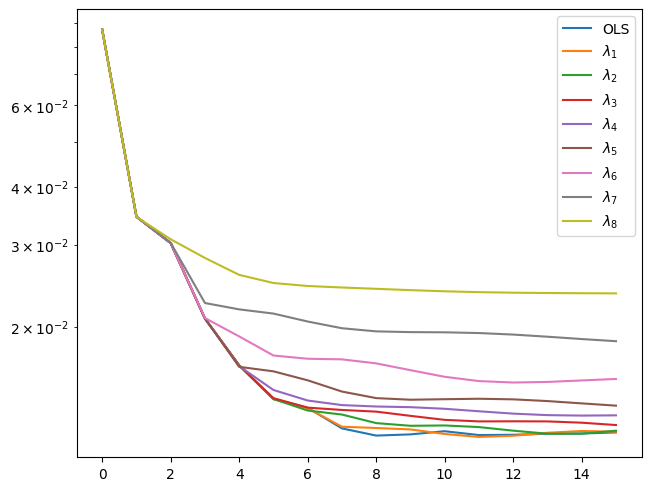

In [30]:
fig, ax1 = plt.subplots(layout='constrained')
# ax2 = ax1.twinx()
ax1.plot(np.arange(P), ols_mse, label='OLS')
for i in range(n_lmbdas):
    # ax.plot(np.arange(P), train_mse, label=r'MSE$_{train}$')
    # ax.plot(np.arange(P), train_r2, label=r'R$^{2}_{train}$')
    ax1.plot(np.arange(P), test_mse.T[i], label=rf'$\lambda_{i+1}$')
    # ax2.plot(np.arange(P), test_r2.T[i])
ax1.legend()
ax1.set_yscale('log')

# fig.savefig('../latex/figures/betas.pdf')
plt.show()

## Lasso

In [14]:
class LassoRegression:

    def __init__(self, lmbda, max_iter=10_000) -> None:
        self._model = Lasso(fit_intercept=True, max_iter=max_iter, alpha=lmbda)
        self._beta = None

    @property
    def beta(self):
        return self._beta
        
    def fit(self, X_train, y_train):
        # Needs implementation for Lasso, using sklearn
        self._beta = self._model.fit(X_train, y_train)
        return self

    def predict(self, X_test):
        return self._model.predict(X_test)

In [15]:
N = 40
P = 15+1
n_lmbdas = 8
lmbdas = [1/(10**i) for i in range(n_lmbdas-1, -1, -1)]

x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 1)

In [16]:
ols_mse = np.zeros(P)
ols_r2 = np.zeros(P)
test_mse = np.zeros((P, n_lmbdas))
test_r2 = np.zeros((P, n_lmbdas))

In [17]:
# import warnings
# warnings.filterwarnings('ignore')

from tqdm import tqdm

In [18]:
for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=12)

    ols = OLSRegression()
    ols.fit(X_train, y_train)
    ols_pred = ols.predict(X_test)

    ols_mse[p] = mse(y_test, ols_pred)
    ols_r2[p] = r2(y_test, ols_pred)
    
    for i, lmbda in tqdm(enumerate(lmbdas)):
        model = LassoRegression(lmbda)
        model.fit(X_train, y_train)

        # beta = model.beta
        # betas.append(beta)
        # beta_mean.append(np.mean(beta))
        # beta_std.append(np.std(beta))

        y_tilde = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        # train_mse[p][i] = mse(y_train, y_tilde)
        # train_r2[p][i] = r2(y_train, y_tilde)
        test_mse[p][i] = mse(y_test, y_pred)
        test_r2[p][i] = r2(y_test, y_pred)

8it [00:00, 1447.75it/s]
8it [00:00, 1283.25it/s]
8it [00:00, 806.85it/s]
8it [00:01,  6.35it/s]
0it [00:00, ?it/s]/Users/jovie/miniconda3/envs/fys-stk4155/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.920e+00, tolerance: 1.292e-01
  model = cd_fast.enet_coordinate_descent(
1it [00:01,  1.70s/it]/Users/jovie/miniconda3/envs/fys-stk4155/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+00, tolerance: 1.292e-01
  model = cd_fast.enet_coordinate_descent(
8it [00:05,  1.51it/s]
0it [00:02, ?it/s]


KeyboardInterrupt: 

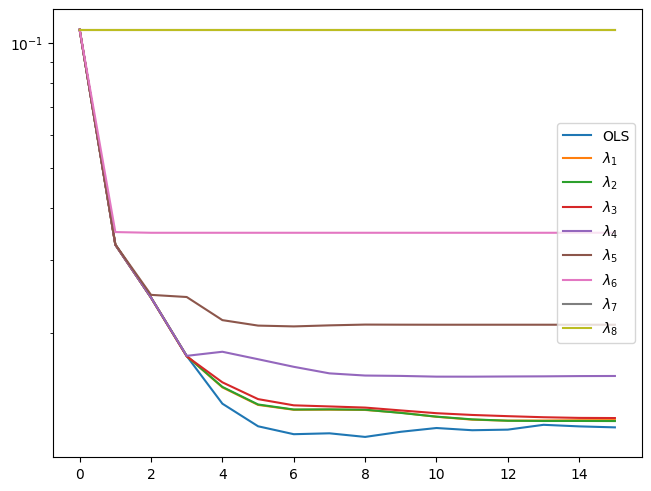

In [49]:
fig, ax1 = plt.subplots(layout='constrained')
# ax2 = ax1.twinx()
ax1.plot(np.arange(P), ols_mse, label='OLS')
for i in range(n_lmbdas):
    # ax.plot(np.arange(P), train_mse, label=r'MSE$_{train}$')
    # ax.plot(np.arange(P), train_r2, label=r'R$^{2}_{train}$')
    ax1.plot(np.arange(P), test_mse.T[i], label=rf'$\lambda_{i+1}$')
    # ax2.plot(np.arange(P), test_r2.T[i])
ax1.legend()
ax1.set_yscale('log')

# fig.savefig('../latex/figures/betas.pdf')
plt.show()

## Bias-Variance

In [118]:
N = 40
P = 15+1

np.random.seed(24)

x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 0.6)

In [119]:
degrees = np.arange(P)
train_mse = np.zeros(P)
test_mse = np.zeros(P)


In [120]:


for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=12)

    ols = OLSRegression()
    ols.fit(X_train, y_train)
    y_tilde = ols.predict(X_train)
    y_pred = ols.predict(X_test)

    train_mse[p] = mse(y_train, y_tilde)
    test_mse[p] = mse(y_test, y_pred)



[]

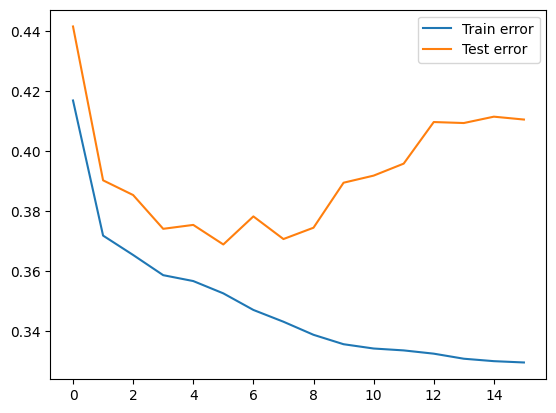

In [121]:
fig, ax = plt.subplots()
ax.plot(degrees, train_mse, label='Train error')
ax.plot(degrees, test_mse, label='Test error')
# ax.set_yscale('log')
ax.legend()
plt.plot()

In [ ]:
def bootstrap_ols(x, y, z, degree, num_bootstraps=100):
    """Resampling data using bootstrap algorithm.
    
    Args:
        x (np.ndarray): x-values
        y (np.ndarray): y-values
        z (np.ndarray): values of Franke function
        degree (int): polynomial degree
        num_bootstraps (int): number of resamples
        
    Returns:
        tuple: Error of train and test, bias and variance
    """
    X = design_matrix(x, y, degree)
    X_train, X_test, z_train, z_test = train_test_split(X, z.flatten(), test_size=0.2)

    z_tilde = np.empty((z_train.shape[0], num_bootstraps))
    z_predict = np.empty((z_test.shape[0], num_bootstraps))

    mse_train = np.empty(num_bootstraps)
    mse_test = np.empty(num_bootstraps)

    for i in range(num_bootstraps):
        X_, z_ = resample(X_train, z_train)
        beta = beta_OLS(X_, z_)
        # beta = beta_ols(X_, z_)

        z_tilde[:, i] = (X_ @ beta).ravel() 
        z_predict[:, i] = (X_test @ beta).ravel() 

        mse_train[i] = mse(z_, z_tilde[:, i])
        mse_test[i] = mse(z_test, z_predict[:, i])

    error_train = np.mean(mse_train)
    error_test = np.mean(mse_test)
    bias = np.mean((z_test - np.mean(z_predict, axis=1))**2)
    variance = np.mean(np.var(z_predict, axis=1, keepdims=True))

    return (error_train, error_test, bias, variance)

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

class Bootstrapper:

    def __init__(self, model, method, param):
        self._model = model
        self._method = method 
        self._param = param
    
    # def _k_fold(self, data):
    #     n_samples = len(data)
    #     fold_size = n_samples // self._param
    #     indices = np.arange(n_samples)
    #     np.random.shuffle(indices)
    #     k_fold_indices = []
    #     for i in range(self._param):
    #         test_start = i * fold_size
    #         test_end = (i + 1) * fold_size
    #         test_indices = indices[test_start:test_end]
    #         train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
    #         k_fold_indices.append((train_indices, test_indices))
    #     return k_fold_indices

    def _bootstrap(self, x1, x2, y, degree):
        degrees = np.arange(degree)
        error_test = np.zeros(degree)
        bias = np.zeros(degree)
        variance = np.zeros(degree)

        X = np.column_stack((x1.ravel(), x2.ravel()))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        x1_train = X_train[:, 0]
        x2_train = X_train[:, 1]

        x1_test = X_test[:, 0]
        x2_test = X_test[:, 1]

        for p in tqdm(range(degree)):
            Xtrain = design_matrix(x1_train, x2_train, p)
            Xtest = design_matrix(x1_test, x2_test, p)

            y_pred = np.empty((y_test.shape[0], self._param))
            mse_test = np.empty(self._param)

            for i in range(self._param):
                X_, y_ = resample(Xtrain, y_train)
                self._model.fit(X_, y_)

                # y_tilde[:, i] = model.predict(X_).ravel()
                y_pred[:, i] = self._model.predict(Xtest).ravel()

                # mse_train[i] = mse(y_, y_tilde[:, i])
                mse_test[i] = mse(y_test, y_pred[:, i])

            error_test[p] = np.mean(mse_test)
            bias[p] = np.mean((y_test - np.mean(y_pred, axis=1))**2)
            variance[p] = np.mean(np.var(y_pred, axis=1, keepdims=True))
        
        return (degrees, error_test, bias, variance)

    def _crossval(self, x1, x2, y, degree):
        degrees = np.arange(degree)
        error_test = np.zeros(degree)

        X = np.column_stack((x1.ravel(), x2.ravel()))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        x1_train = X_train[:, 0]
        x2_train = X_train[:, 1]

        x1_test = X_test[:, 0]
        x2_test = X_test[:, 1]
        for p in tqdm(range(degree)):
            Xtrain = design_matrix(x1_train, x2_train, p)
            Xtest = design_matrix(x1_test, x2_test, p)

            self._model.fit(Xtrain, y_train)

            cross_val_score(self._model, Xtest, y_test, scoring='neg_mean_squared_error', cv=self._param)

            y_pred = self._model.predict(Xtest)
            error_test[p] = mse(y_test, y_pred)
        
        return (degrees, error_test)

    # def _crossval(self, x1, x2, y, degree):
    #     X = design_matrix(x, y, degree)
    #     train_scores = np.zeros(self._param)
    #     scores_KFold_test = np.zeros(self._param)
    #     k_fold_indices = k_fold(X, self._param)

    #     for j, (train_indices, test_indices) in enumerate(k_fold_indices):
    #         X_train, X_test = X[train_indices], X[test_indices]
    #         z_train, z_test = z[train_indices], z[test_indices]

    #         beta = beta_ols(X_train, z_train)

    #         z_tilde = (X_train @ beta).ravel()
    #         z_predict = (X_test @ beta).ravel()
    #         train_scores[j] = mse(z_train, z_tilde)
    #         scores_KFold_test[j] = mse(z_test, z_predict)
    #     mse_train_ols = np.mean(train_scores)
    #     mse_test_ols = np.mean(scores_KFold_test)

    #     return (mse_train_ols, mse_test_ols)
    
    def run(self, x1, x2, y, degree):
        
        if self._method == 'cv':
            return self._crossval(x1, x2, y, degree)

        else:
            return self._bootstrap(x1, x2, y, degree)



In [152]:
model = OLSRegression()
method = 'bootstrap'
param = 100

bs = Bootstrapper(model, method, param)

In [151]:
N = 40
P = 15+1

np.random.seed(2024)

x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 0.1)

degrees, error_test, bias, variance = bs.run(x1, x2, y.ravel(), P)

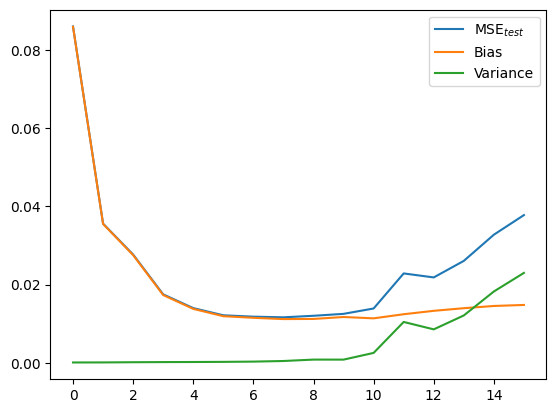

In [148]:
fig, ax = plt.subplots()
ax.plot(degrees, error_test, label=r'MSE$_{test}$')
ax.plot(degrees, bias, label='Bias')
ax.plot(degrees, variance, label='Variance')
ax.legend()
# ax.set_yscale('log')
plt.show()

## Cross-validation

In [172]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()
method = 'cv'
param = 5

cv = Bootstrapper(model, method, param)

In [173]:
N = 40
P = 15+1

np.random.seed(2024)

x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 0.1)

In [174]:
degrees, error_test = cv.run(x1, x2, y.ravel(), P)

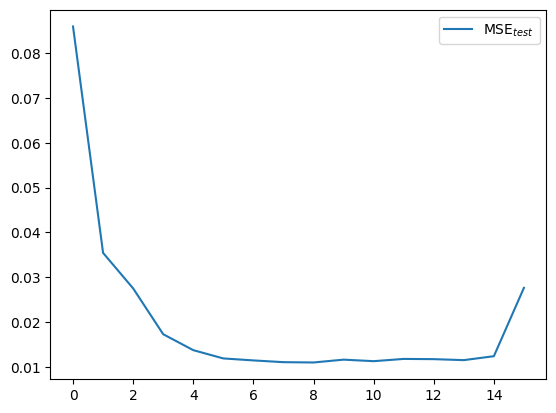

In [175]:
fig, ax = plt.subplots()
ax.plot(degrees, error_test, label=r'MSE$_{test}$')
ax.legend()
# ax.set_yscale('log')
plt.show()

## Real terrain

### Oslo

In [18]:
from imageio.v3 import imread

oslo = '../data/n59_e010_1arc_v3.tif'
terrain = imread(oslo)

In [19]:
N = 40
P = 15+1

np.random.seed(2024)

In [20]:
y = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        y[i, j] = terrain[i, j]
y = y.ravel()
y_scaled = (y - y.mean()) / y.std()
# y = (y - y.mean) / y.std

# Create x and y
x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2= np.meshgrid(x1_, x2_)

In [24]:
train_mse = np.zeros(P)
train_r2 = np.zeros(P)
test_mse = np.zeros(P)
test_r2 = np.zeros(P)
degrees = np.arange(P)

In [25]:
for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=12)

    model = OLSRegression()
    model.fit(X_train, y_train)

    # beta = model.beta
    # betas.append(beta)
    # beta_mean.append(np.mean(beta))
    # beta_std.append(np.std(beta))

    y_tilde = model.predict(X_train)
    y_pred = model.predict(X_test)

    train_mse[p] = mse(y_train, y_tilde)
    train_r2[p] = r2(y_train, y_tilde)
    test_mse[p] = mse(y_test, y_pred)
    test_r2[p] = r2(y_test, y_pred)

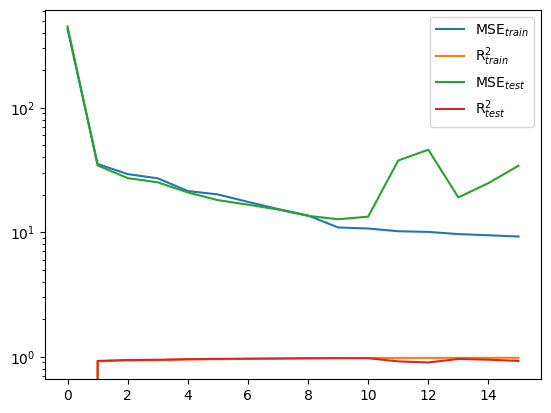

In [27]:
fig, ax = plt.subplots()
ax.plot(degrees, train_mse, label=r'MSE$_{train}$')
ax.plot(degrees, train_r2, label=r'R$^{2}_{train}$')
ax.plot(degrees, test_mse, label=r'MSE$_{test}$')
ax.plot(degrees, test_r2, label=r'R$^{2}_{test}$')
ax.legend()
ax.set_yscale('log')
plt.show()

## Japan

In [65]:
from imageio.v3 import imread

japan = '../data/n34_e135_1arc_v3.tif'
terrain = imread(japan)

### OLS

In [66]:
N = 100
P = 15+1

y = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        y[i, j] = terrain[i, j]
y = y.ravel()
y_scaled = (y - y.mean()) / y.std()
# y = (y - y.mean) / y.std

# Create x and y
x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2= np.meshgrid(x1_, x2_)

In [67]:
train_mse = np.zeros(P)
train_r2 = np.zeros(P)
test_mse = np.zeros(P)
test_r2 = np.zeros(P)
degrees = np.arange(P)

In [68]:
for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2)

    model = OLSRegression()
    model.fit(X_train, y_train)

    # beta = model.beta
    # betas.append(beta)
    # beta_mean.append(np.mean(beta))
    # beta_std.append(np.std(beta))

    y_tilde = model.predict(X_train)
    y_pred = model.predict(X_test)

    train_mse[p] = mse(y_train, y_tilde)
    train_r2[p] = r2(y_train, y_tilde)
    test_mse[p] = mse(y_test, y_pred)
    test_r2[p] = r2(y_test, y_pred)

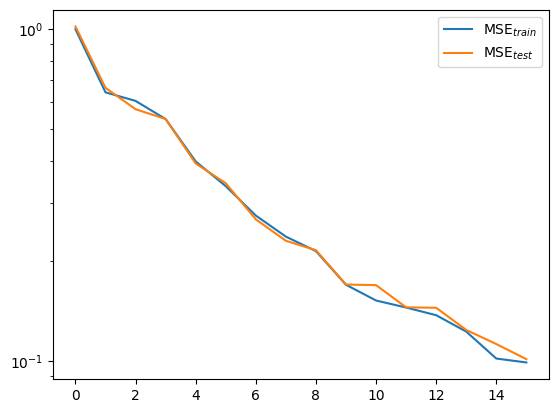

In [69]:
fig, ax = plt.subplots()
ax.plot(degrees, train_mse, label=r'MSE$_{train}$')
# ax.plot(degrees, train_r2, label=r'R$^{2}_{train}$')
ax.plot(degrees, test_mse, label=r'MSE$_{test}$')
# ax.plot(degrees, test_r2, label=r'R$^{2}_{test}$')
ax.legend()
ax.set_yscale('log')
plt.show()

### Ridge

In [70]:
N = 100
P = 15+1
n_lmbdas = 8
lmbdas = [1/(10**i) for i in range(n_lmbdas-1, -1, -1)]

test_mse = np.zeros((P, n_lmbdas))
train_mse = np.zeros((P, n_lmbdas))
test_r2 = np.zeros((P, n_lmbdas))
train_r2 = np.zeros((P, n_lmbdas))
degrees = np.arange(P)

In [71]:
for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2)
    
    for i, lmbda in enumerate(lmbdas):
        model = RidgeRegression(lmbda)
        model.fit(X_train, y_train)

        y_tilde = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        train_mse[p][i] = mse(y_train, y_tilde)
        train_r2[p][i] = r2(y_train, y_tilde)
        test_mse[p][i] = mse(y_test, y_pred)
        test_r2[p][i] = r2(y_test, y_pred)

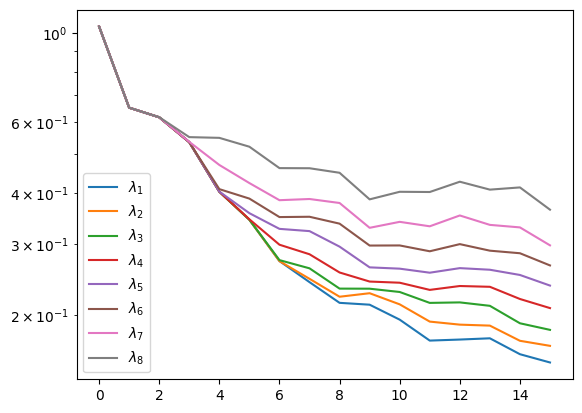

In [72]:
fig, ax = plt.subplots()
for i in range(n_lmbdas):
    ax.plot(degrees, test_mse.T[i], label=rf'$\lambda_{i+1}$')
ax.legend()
ax.set_yscale('log')

## Lasso

In [73]:
import warnings
warnings.filterwarnings('ignore')

class LassoRegression:

    def __init__(self, lmbda) -> None:
        self._model = Lasso(lmbda)
        self._beta = None

    @property
    def beta(self):
        return self._beta
        
    def fit(self, X_train, y_train):
        # Needs implementation for Lasso, using sklearn
        self._beta = self._model.fit(X_train, y_train)

    def predict(self, X_test):
        return self._model.predict(X_test)

In [74]:
N = 100
P = 15+1
n_lmbdas = 8
lmbdas = [1/(10**i) for i in range(n_lmbdas-1, -1, -1)]

test_mse = np.zeros((P, n_lmbdas))
train_mse = np.zeros((P, n_lmbdas))
test_r2 = np.zeros((P, n_lmbdas))
train_r2 = np.zeros((P, n_lmbdas))
degrees = np.arange(P)

In [75]:
for p in tqdm(range(P)):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2)
    
    for i, lmbda in enumerate(lmbdas):
        model = LassoRegression(lmbda)
        model.fit(X_train, y_train)

        y_tilde = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        train_mse[p][i] = mse(y_train, y_tilde)
        train_r2[p][i] = r2(y_train, y_tilde)
        test_mse[p][i] = mse(y_test, y_pred)
        test_r2[p][i] = r2(y_test, y_pred)

100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


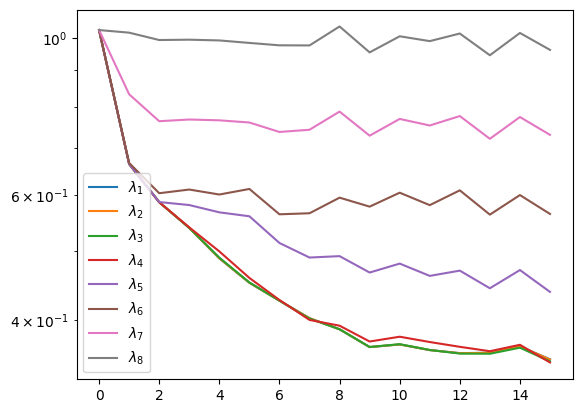

In [76]:
fig, ax = plt.subplots()
for i in range(n_lmbdas):
    # ax.plot(np.arange(P), train_mse, label=r'MSE$_{train}$')
    # ax.plot(np.arange(P), train_r2, label=r'R$^{2}_{train}$')
    ax.plot(degrees, test_mse.T[i], label=rf'$\lambda_{i+1}$')
    # ax2.plot(np.arange(P), test_r2.T[i])
ax.legend()
ax.set_yscale('log')

# fig.savefig('../latex/figures/betas.pdf')
plt.show()

## Bias-Variance

In [77]:
N = 100
P = 15+1

x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)

In [78]:
train_mse = np.zeros(P)
test_mse = np.zeros(P)
degrees = np.arange(P)

In [79]:
for p in range(P):
    X = design_matrix(x1, x2, p)
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2)

    ols = OLSRegression()
    ols.fit(X_train, y_train)
    y_tilde = ols.predict(X_train)
    y_pred = ols.predict(X_test)

    train_mse[p] = mse(y_train, y_tilde)
    test_mse[p] = mse(y_test, y_pred)

[]

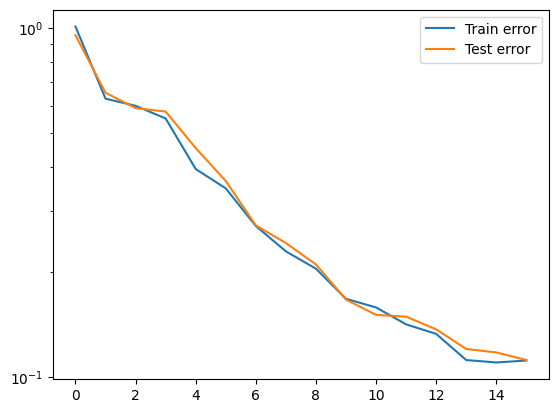

In [80]:
fig, ax = plt.subplots()
ax.plot(degrees, train_mse, label='Train error')
ax.plot(degrees, test_mse, label='Test error')
ax.legend()
ax.set_yscale('log')
plt.plot()

## Bootstrap

In [81]:
# N = 40
# P = 15+1

model = OLSRegression()
method = 'bootstrap'
param = 1000

bs = Bootstrapper(model, method, param)

In [82]:
x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)
# y = franke_function(x1, x2, 0.1)

degrees, error_test, bias, variance = bs.run(x1, x2, y_scaled, P)

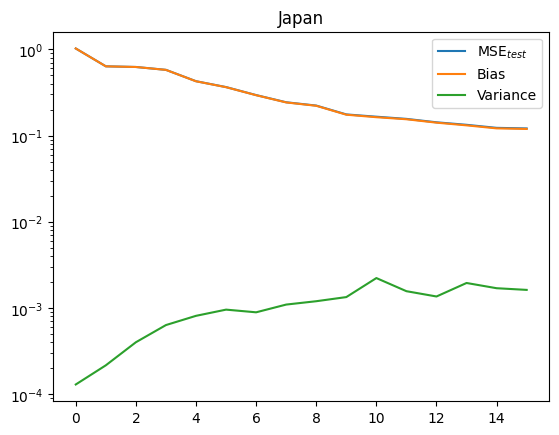

In [83]:
fig, ax = plt.subplots()
ax.plot(degrees, error_test, label=r'MSE$_{test}$')
ax.plot(degrees, bias, label='Bias')
ax.plot(degrees, variance, label='Variance')
ax.legend()
ax.set_yscale('log')
ax.set_title("Japan")
plt.show()

## Cross-validation

In [84]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
method = 'cv'
param = 10

cv = Bootstrapper(model, method, param)

In [85]:
N = 100
P = 15+1

x1_ = np.sort(np.random.uniform(0, 1, N))
x2_ = np.sort(np.random.uniform(0, 1, N))
x1, x2 = np.meshgrid(x1_, x2_)

In [86]:
degrees, error_test = cv.run(x1, x2, y_scaled, P)

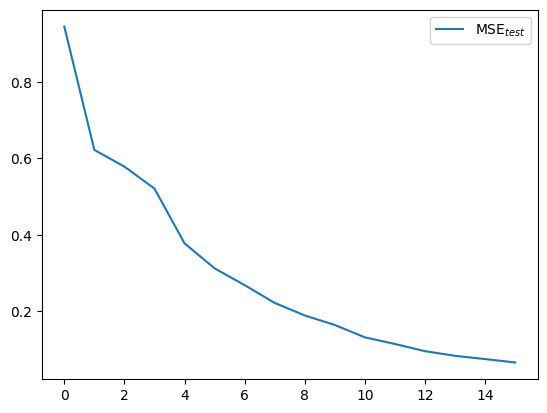

In [88]:
fig, ax = plt.subplots()
ax.plot(degrees, error_test, label=r'MSE$_{test}$')
ax.legend()
# ax.set_yscale('log')
plt.show()